In [2]:
import numpy as np
import matplotlib.pyplot as plt

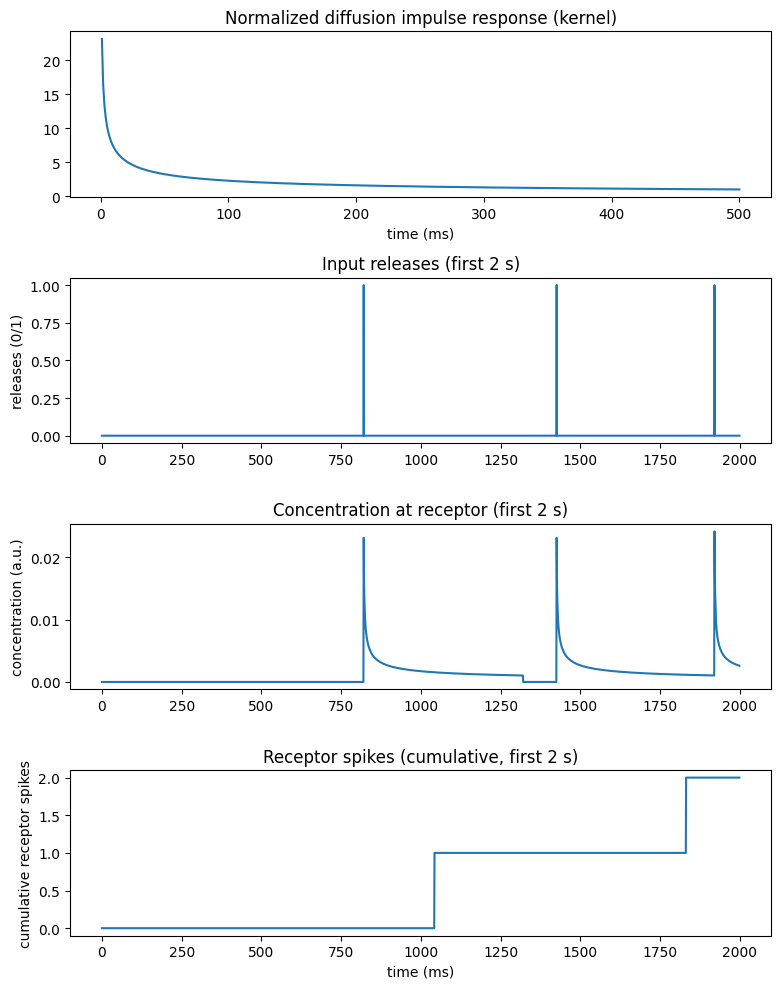

Simulation duration: 20.0 s, dt = 0.001 s, analysis bin = 10 ms
Release rate: 5.0 Hz (mean releases per analysis bin = 0.0415)
Receptor mean firing rate (observed): 1.600 Hz
Mutual information (per bin): 0.001499 bits
Mutual information rate: 0.149874 bits/s


In [4]:
# Simulate Poisson releases -> diffusion channel -> receptor sampling
# and estimate mutual information between binned releases and binned receptor counts.
# This code will plot the diffusion kernel and example traces, and print a mutual information estimate.
import numpy as np
import matplotlib.pyplot as plt
from math import log2

np.random.seed(42)

# Simulation parameters
dt = 0.001               # time step (s) -> 1 ms
T = 20.0                 # total duration (s)
steps = int(T / dt)

# Release (input) parameters
lambda_release = 5.0     # mean release rate (Hz)
Q = 1.0                  # quanta amplitude per release (arbitrary units)

# Diffusion kernel parameters (1D radial profile at distance r)
D = 0.5e-6               # diffusion coefficient (m^2 / s) -- small value; units chosen to keep kernel visible
# Note: to keep units intuitive with dt in s and r in micrometers, we choose D in m^2/s and r in meters.
r_um = 0.5               # receptor distance in micrometers
r = r_um * 1e-6          # convert to meters

# Kernel duration and array
kernel_T = 0.5           # kernel length in seconds (500 ms)
kernel_steps = int(kernel_T / dt)
t_k = np.arange(1, kernel_steps + 1) * dt  # avoid t=0 singularity

# 1D Green's function for diffusion (point-source observed at distance r)
# G_1D(r,t) ~ (1/sqrt(4*pi*D*t)) * exp(-r^2/(4*D*t))
h = (1.0 / np.sqrt(4 * np.pi * D * t_k)) * np.exp(-r**2 / (4 * D * t_k))
# We'll normalize kernel so the total area under the impulse response equals 1 (for interpretability)
h = h / (np.sum(h) * dt)

# Generate Poisson release train (0/1 per dt)
p_release = lambda_release * dt
releases = (np.random.rand(steps) < p_release).astype(float)

# Convolve releases with kernel to get concentration-time series (approx integral)
c = np.convolve(releases, h)[:steps] * Q * dt  # multiply by dt because releases approximate impulse area

# Receptor sampling: Poisson spiking with rate proportional to concentration
baseline_rate = 1.0  # Hz baseline spontaneous rate
alpha = 200.0        # scaling factor from concentration -> firing rate (Hz per concentration unit)
rates = baseline_rate + alpha * c  # instantaneous firing rate in Hz (per second)

# Simulate receptor spikes (counts per dt)
receptor_spikes = np.random.poisson(rates * dt)

# Analysis: bin the signal into coarser bins for MI estimation
bin_ms = 10                # analysis bin size in ms
bin_size = int((bin_ms / 1000.0) / dt)
n_bins = steps // bin_size

# Bin inputs (number of releases in each analysis bin) and outputs (receptor spike counts)
x_binned = np.array([releases[i*bin_size:(i+1)*bin_size].sum() for i in range(n_bins)])
y_binned = np.array([receptor_spikes[i*bin_size:(i+1)*bin_size].sum() for i in range(n_bins)])
time_binned = np.arange(n_bins) * (bin_ms / 1000.0)

# Cap counts for histogramming (to avoid huge sparse histograms)
x_max = int(max(3, np.percentile(x_binned, 99)))  # usually 0 or 1, rarely >1
y_max = int(min(20, np.percentile(y_binned, 99))) # cap at 20 for display

x_vals = np.minimum(x_binned.astype(int), x_max)
y_vals = np.minimum(y_binned.astype(int), y_max)

# Compute empirical joint distribution P(x,y) and MI (in bits)
def mutual_information_discrete(x, y, x_max_val=None, y_max_val=None):
    if x_max_val is None: x_max_val = int(x.max())
    if y_max_val is None: y_max_val = int(y.max())
    x_bins = np.arange(0, x_max_val + 2) - 0.5
    y_bins = np.arange(0, y_max_val + 2) - 0.5
    hist2d, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])
    p_xy = hist2d / hist2d.sum()
    p_x = p_xy.sum(axis=1)
    p_y = p_xy.sum(axis=0)
    mi = 0.0
    for i in range(p_xy.shape[0]):
        for j in range(p_xy.shape[1]):
            p = p_xy[i, j]
            if p > 0:
                mi += p * log2(p / (p_x[i] * p_y[j]))
    return mi, p_xy, p_x, p_y

mi_bits, p_xy, p_x, p_y = mutual_information_discrete(x_vals, y_vals, x_max_val=x_max, y_max_val=y_max)
# Convert to rate (bits per second)
mi_bps = mi_bits / (bin_ms / 1000.0)

# Plots: kernel, example snippet of releases, concentration, and receptor spikes (downsampled)
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=False)

# Kernel in ms
axes[0].plot(t_k * 1000.0, h)
axes[0].set_xlabel('time (ms)')
axes[0].set_title('Normalized diffusion impulse response (kernel)')

# Example trace: first 2000 ms
end_plot_s = 2.0
end_idx = int(end_plot_s / dt)
t = np.arange(end_idx) * dt
axes[1].plot(t * 1000.0, releases[:end_idx])
axes[1].set_ylabel('releases (0/1)')
axes[1].set_title('Input releases (first 2 s)')

axes[2].plot(t * 1000.0, c[:end_idx])
axes[2].set_ylabel('concentration (a.u.)')
axes[2].set_title('Concentration at receptor (first 2 s)')

axes[3].plot(t * 1000.0, np.cumsum(receptor_spikes[:end_idx]))  # cumulative to visualize spike events
axes[3].set_ylabel('cumulative receptor spikes')
axes[3].set_xlabel('time (ms)')
axes[3].set_title('Receptor spikes (cumulative, first 2 s)')

plt.tight_layout()
plt.show()

# Print summary statistics and MI
print(f"Simulation duration: {T} s, dt = {dt} s, analysis bin = {bin_ms} ms")
print(f"Release rate: {lambda_release} Hz (mean releases per analysis bin = {x_binned.mean():.4f})")
print(f"Receptor mean firing rate (observed): {receptor_spikes.sum() / T:.3f} Hz")
print(f"Mutual information (per bin): {mi_bits:.6f} bits")
print(f"Mutual information rate: {mi_bps:.6f} bits/s")

# Also show marginal distributions
import pandas as pd
marginal_df = pd.DataFrame({
    'x_bin_value': np.arange(len(p_x)),
    'p_x': p_x,
})
marginal_df_y = pd.DataFrame({
    'y_bin_value': np.arange(len(p_y)),
    'p_y': p_y,
})

